# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 60.0k/60.0k [02:54<00:00, 344File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

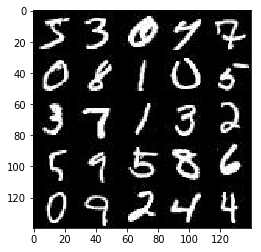

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

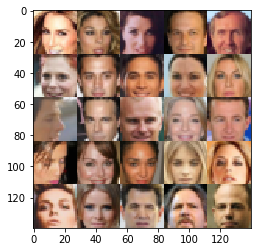

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [143]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, [], name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [179]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        # 1
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [218]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        alpha=0.2
        
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 2x2x512 now
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='valid')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x256 now
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 14x14x128 now
                
        # Output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
               
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [181]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [183]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [168]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [211]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # Image params
    _, image_width, image_height, image_channels = data_shape  
    print("image_width={}, image_height={}, image_channels={}".format(image_width, image_height, image_channels))
    
    # Get the placeholders
    inputs_real, inputs_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Get the loss
    d_loss, g_loss = model_loss(inputs_real, inputs_z, image_channels)
    
    # Get the optimization operations
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 25
    show_every = 100
    n_images = 4
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                
                # Scale images to range of -1 to 1 to match generator range
                batch_images *= 2.0
                               
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr : learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, lr : learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                   
                    print("Epoch {}/{}: Discriminator Loss: {:.4f}, Generator Loss: {:.4f}".format(epoch_i, epoch_count, train_loss_d, train_loss_g))
                          
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, inputs_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

image_width=28, image_height=28, image_channels=1
Epoch 0/2: Discriminator Loss: 0.0246, Generator Loss: 10.4223
Epoch 0/2: Discriminator Loss: 0.0919, Generator Loss: 4.1909
Epoch 0/2: Discriminator Loss: 0.2061, Generator Loss: 2.7866
Epoch 0/2: Discriminator Loss: 0.7312, Generator Loss: 2.0479


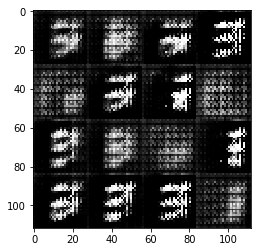

Epoch 0/2: Discriminator Loss: 2.1926, Generator Loss: 5.5520
Epoch 0/2: Discriminator Loss: 1.7698, Generator Loss: 0.3313
Epoch 0/2: Discriminator Loss: 1.1296, Generator Loss: 3.7464
Epoch 0/2: Discriminator Loss: 0.9322, Generator Loss: 5.3103


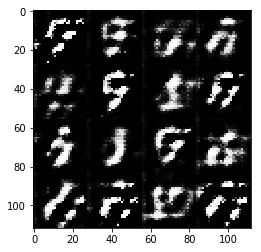

Epoch 0/2: Discriminator Loss: 0.4345, Generator Loss: 2.1170
Epoch 0/2: Discriminator Loss: 0.4727, Generator Loss: 1.9953
Epoch 0/2: Discriminator Loss: 0.8148, Generator Loss: 3.2805
Epoch 0/2: Discriminator Loss: 0.7631, Generator Loss: 1.5487


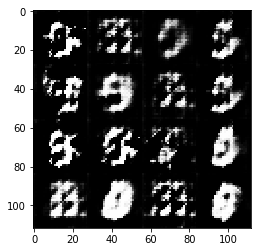

Epoch 0/2: Discriminator Loss: 0.6594, Generator Loss: 1.3582
Epoch 0/2: Discriminator Loss: 1.7887, Generator Loss: 0.4743
Epoch 0/2: Discriminator Loss: 0.8066, Generator Loss: 1.1943
Epoch 0/2: Discriminator Loss: 1.3045, Generator Loss: 0.7659


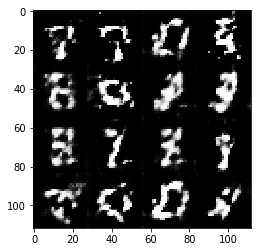

Epoch 0/2: Discriminator Loss: 1.0472, Generator Loss: 1.1088
Epoch 0/2: Discriminator Loss: 0.5258, Generator Loss: 3.6508
Epoch 0/2: Discriminator Loss: 1.6974, Generator Loss: 3.0799
Epoch 0/2: Discriminator Loss: 0.8380, Generator Loss: 1.0650


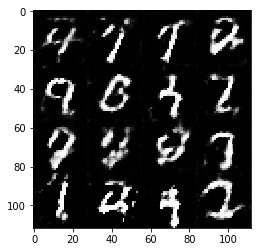

Epoch 0/2: Discriminator Loss: 0.9044, Generator Loss: 0.9237
Epoch 0/2: Discriminator Loss: 0.8848, Generator Loss: 0.9987
Epoch 0/2: Discriminator Loss: 0.8860, Generator Loss: 1.2065
Epoch 0/2: Discriminator Loss: 0.8122, Generator Loss: 1.8638


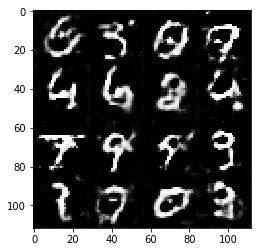

Epoch 0/2: Discriminator Loss: 0.9149, Generator Loss: 0.9428
Epoch 0/2: Discriminator Loss: 1.7433, Generator Loss: 0.3899
Epoch 0/2: Discriminator Loss: 1.1990, Generator Loss: 1.7819
Epoch 0/2: Discriminator Loss: 0.8858, Generator Loss: 0.9767


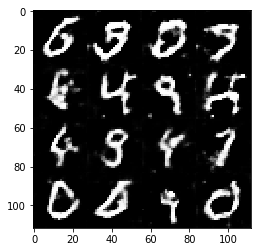

Epoch 0/2: Discriminator Loss: 0.7405, Generator Loss: 1.3154
Epoch 0/2: Discriminator Loss: 3.0403, Generator Loss: 5.0626
Epoch 0/2: Discriminator Loss: 0.9391, Generator Loss: 0.9424
Epoch 0/2: Discriminator Loss: 0.9181, Generator Loss: 0.8966


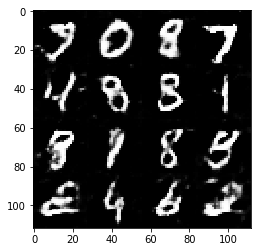

Epoch 0/2: Discriminator Loss: 1.4658, Generator Loss: 2.9716
Epoch 0/2: Discriminator Loss: 1.0512, Generator Loss: 1.3763
Epoch 0/2: Discriminator Loss: 0.9998, Generator Loss: 1.4030
Epoch 0/2: Discriminator Loss: 0.8156, Generator Loss: 1.0845


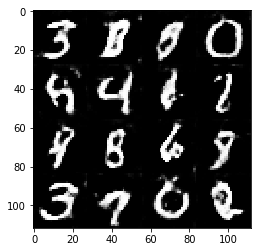

Epoch 0/2: Discriminator Loss: 1.3750, Generator Loss: 0.8286


KeyboardInterrupt: 

In [219]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

image_width=28, image_height=28, image_channels=3
Epoch 0/1: Discriminator Loss: 4.0335, Generator Loss: 11.8832
Epoch 0/1: Discriminator Loss: 3.5210, Generator Loss: 0.0762
Epoch 0/1: Discriminator Loss: 1.2556, Generator Loss: 0.7405
Epoch 0/1: Discriminator Loss: 1.8888, Generator Loss: 0.2645


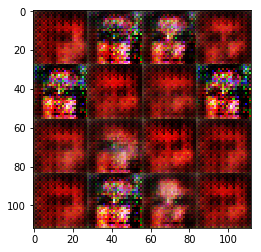

Epoch 0/1: Discriminator Loss: 0.7573, Generator Loss: 4.5595
Epoch 0/1: Discriminator Loss: 0.7155, Generator Loss: 2.2932
Epoch 0/1: Discriminator Loss: 0.8615, Generator Loss: 1.0644
Epoch 0/1: Discriminator Loss: 0.3919, Generator Loss: 2.5296


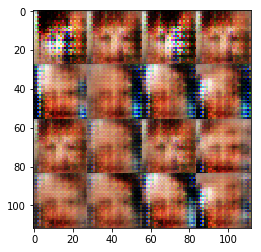

Epoch 0/1: Discriminator Loss: 1.6745, Generator Loss: 0.2956
Epoch 0/1: Discriminator Loss: 0.8062, Generator Loss: 1.1075
Epoch 0/1: Discriminator Loss: 1.3149, Generator Loss: 1.7728
Epoch 0/1: Discriminator Loss: 1.4685, Generator Loss: 0.6652


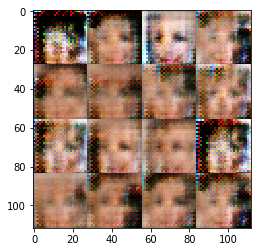

Epoch 0/1: Discriminator Loss: 1.5418, Generator Loss: 0.5614
Epoch 0/1: Discriminator Loss: 2.1496, Generator Loss: 1.8999
Epoch 0/1: Discriminator Loss: 1.1831, Generator Loss: 0.7868
Epoch 0/1: Discriminator Loss: 1.5982, Generator Loss: 0.3056


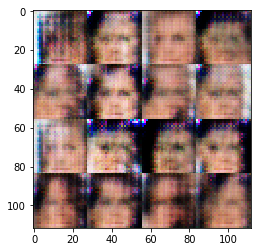

Epoch 0/1: Discriminator Loss: 0.8416, Generator Loss: 1.4219
Epoch 0/1: Discriminator Loss: 1.1109, Generator Loss: 0.8200
Epoch 0/1: Discriminator Loss: 1.1963, Generator Loss: 0.6810
Epoch 0/1: Discriminator Loss: 2.3714, Generator Loss: 3.0022


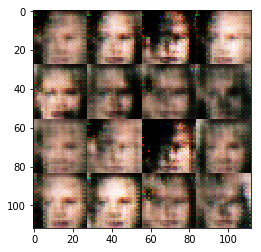

Epoch 0/1: Discriminator Loss: 1.3114, Generator Loss: 1.3740
Epoch 0/1: Discriminator Loss: 1.1577, Generator Loss: 0.7327
Epoch 0/1: Discriminator Loss: 2.4157, Generator Loss: 3.6289
Epoch 0/1: Discriminator Loss: 1.0216, Generator Loss: 1.1992


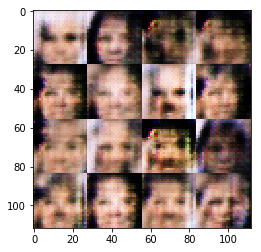

Epoch 0/1: Discriminator Loss: 1.9706, Generator Loss: 0.2943
Epoch 0/1: Discriminator Loss: 1.5599, Generator Loss: 1.5373
Epoch 0/1: Discriminator Loss: 1.2484, Generator Loss: 0.6770
Epoch 0/1: Discriminator Loss: 1.4603, Generator Loss: 1.9037


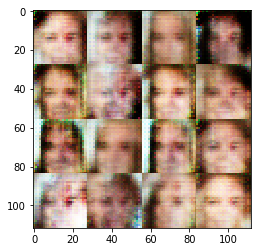

Epoch 0/1: Discriminator Loss: 1.0460, Generator Loss: 0.6841
Epoch 0/1: Discriminator Loss: 1.2964, Generator Loss: 0.7609
Epoch 0/1: Discriminator Loss: 0.9172, Generator Loss: 1.1882
Epoch 0/1: Discriminator Loss: 0.8485, Generator Loss: 0.9599


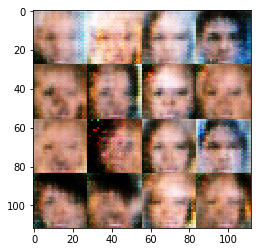

Epoch 0/1: Discriminator Loss: 0.9933, Generator Loss: 0.8455
Epoch 0/1: Discriminator Loss: 1.2937, Generator Loss: 0.5326
Epoch 0/1: Discriminator Loss: 0.9462, Generator Loss: 1.3780
Epoch 0/1: Discriminator Loss: 1.2097, Generator Loss: 0.6086


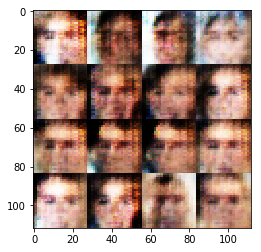

Epoch 0/1: Discriminator Loss: 1.2733, Generator Loss: 0.6220
Epoch 0/1: Discriminator Loss: 1.7958, Generator Loss: 0.2843
Epoch 0/1: Discriminator Loss: 1.1401, Generator Loss: 0.6973
Epoch 0/1: Discriminator Loss: 1.1032, Generator Loss: 0.7410


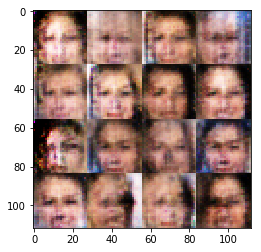

Epoch 0/1: Discriminator Loss: 1.0819, Generator Loss: 0.9555
Epoch 0/1: Discriminator Loss: 1.0443, Generator Loss: 0.8361
Epoch 0/1: Discriminator Loss: 1.1610, Generator Loss: 0.5294
Epoch 0/1: Discriminator Loss: 1.5655, Generator Loss: 0.3921


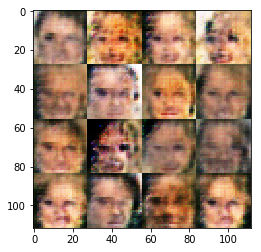

Epoch 0/1: Discriminator Loss: 1.1244, Generator Loss: 0.9144
Epoch 0/1: Discriminator Loss: 1.0950, Generator Loss: 1.2891
Epoch 0/1: Discriminator Loss: 1.6100, Generator Loss: 2.1870
Epoch 0/1: Discriminator Loss: 1.5739, Generator Loss: 0.3869


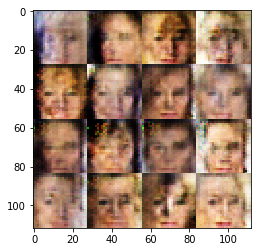

Epoch 0/1: Discriminator Loss: 1.4254, Generator Loss: 1.9855
Epoch 0/1: Discriminator Loss: 1.1366, Generator Loss: 1.3183
Epoch 0/1: Discriminator Loss: 0.8348, Generator Loss: 1.1334
Epoch 0/1: Discriminator Loss: 0.9693, Generator Loss: 0.8881


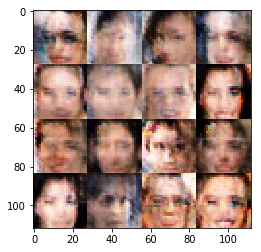

Epoch 0/1: Discriminator Loss: 1.1735, Generator Loss: 1.0758
Epoch 0/1: Discriminator Loss: 1.2810, Generator Loss: 0.7236
Epoch 0/1: Discriminator Loss: 1.2015, Generator Loss: 1.3427
Epoch 0/1: Discriminator Loss: 1.1379, Generator Loss: 0.9222


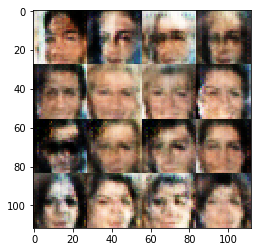

Epoch 0/1: Discriminator Loss: 1.3380, Generator Loss: 0.4999
Epoch 0/1: Discriminator Loss: 1.4824, Generator Loss: 0.4474
Epoch 0/1: Discriminator Loss: 1.2277, Generator Loss: 0.6340
Epoch 0/1: Discriminator Loss: 1.2156, Generator Loss: 0.5647


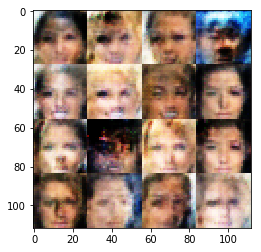

Epoch 0/1: Discriminator Loss: 0.9767, Generator Loss: 1.0016
Epoch 0/1: Discriminator Loss: 0.9387, Generator Loss: 1.0856
Epoch 0/1: Discriminator Loss: 1.0421, Generator Loss: 1.1467
Epoch 0/1: Discriminator Loss: 1.1465, Generator Loss: 1.0270


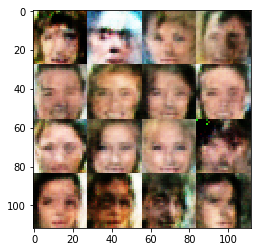

Epoch 0/1: Discriminator Loss: 1.2699, Generator Loss: 0.9321
Epoch 0/1: Discriminator Loss: 1.1958, Generator Loss: 0.6023
Epoch 0/1: Discriminator Loss: 1.0538, Generator Loss: 0.6766
Epoch 0/1: Discriminator Loss: 1.1894, Generator Loss: 0.5516


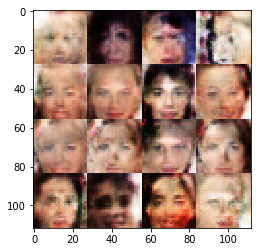

Epoch 0/1: Discriminator Loss: 1.1509, Generator Loss: 1.1845
Epoch 0/1: Discriminator Loss: 0.9945, Generator Loss: 1.2318
Epoch 0/1: Discriminator Loss: 1.3696, Generator Loss: 0.4472
Epoch 0/1: Discriminator Loss: 1.3405, Generator Loss: 1.4763


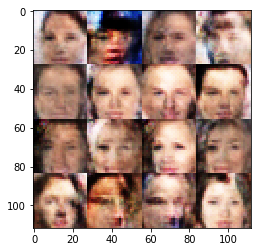

Epoch 0/1: Discriminator Loss: 0.8052, Generator Loss: 1.0473
Epoch 0/1: Discriminator Loss: 1.3260, Generator Loss: 0.4382
Epoch 0/1: Discriminator Loss: 1.0682, Generator Loss: 0.8128
Epoch 0/1: Discriminator Loss: 1.4059, Generator Loss: 1.8917


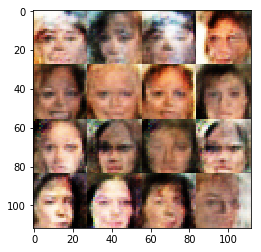

Epoch 0/1: Discriminator Loss: 1.2754, Generator Loss: 0.5802
Epoch 0/1: Discriminator Loss: 1.3048, Generator Loss: 0.7655
Epoch 0/1: Discriminator Loss: 1.0859, Generator Loss: 0.7335
Epoch 0/1: Discriminator Loss: 1.2369, Generator Loss: 2.1894


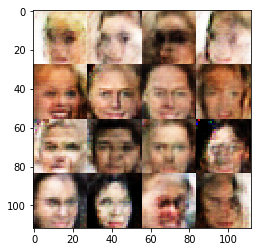

Epoch 0/1: Discriminator Loss: 1.0144, Generator Loss: 0.9026
Epoch 0/1: Discriminator Loss: 1.4425, Generator Loss: 0.4657
Epoch 0/1: Discriminator Loss: 1.0925, Generator Loss: 0.9021
Epoch 0/1: Discriminator Loss: 1.1058, Generator Loss: 1.0434


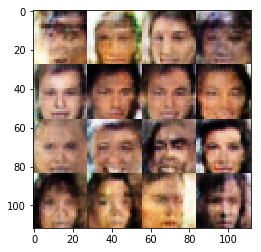

Epoch 0/1: Discriminator Loss: 1.5108, Generator Loss: 1.9322
Epoch 0/1: Discriminator Loss: 1.1628, Generator Loss: 0.5662
Epoch 0/1: Discriminator Loss: 1.0380, Generator Loss: 0.7680
Epoch 0/1: Discriminator Loss: 1.0456, Generator Loss: 0.9076


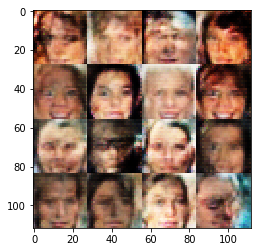

Epoch 0/1: Discriminator Loss: 1.1926, Generator Loss: 1.3695
Epoch 0/1: Discriminator Loss: 1.2122, Generator Loss: 0.6544
Epoch 0/1: Discriminator Loss: 1.0631, Generator Loss: 1.4456
Epoch 0/1: Discriminator Loss: 1.3443, Generator Loss: 0.6813


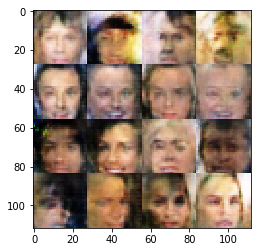

Epoch 0/1: Discriminator Loss: 1.0972, Generator Loss: 1.1178
Epoch 0/1: Discriminator Loss: 1.3031, Generator Loss: 1.0290
Epoch 0/1: Discriminator Loss: 1.4123, Generator Loss: 1.0175
Epoch 0/1: Discriminator Loss: 1.1371, Generator Loss: 1.1230


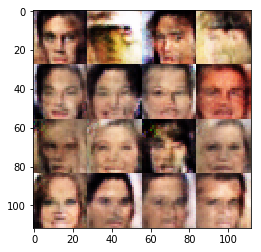

Epoch 0/1: Discriminator Loss: 1.2579, Generator Loss: 0.7533
Epoch 0/1: Discriminator Loss: 1.0485, Generator Loss: 0.9861
Epoch 0/1: Discriminator Loss: 1.1928, Generator Loss: 0.6158
Epoch 0/1: Discriminator Loss: 1.1219, Generator Loss: 0.7626


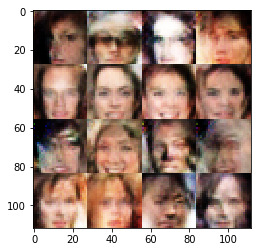

Epoch 0/1: Discriminator Loss: 0.9896, Generator Loss: 1.2450
Epoch 0/1: Discriminator Loss: 1.3832, Generator Loss: 0.7587
Epoch 0/1: Discriminator Loss: 1.1986, Generator Loss: 0.8945
Epoch 0/1: Discriminator Loss: 1.2792, Generator Loss: 0.5661


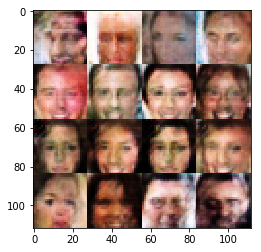

Epoch 0/1: Discriminator Loss: 1.3098, Generator Loss: 0.5318
Epoch 0/1: Discriminator Loss: 1.0359, Generator Loss: 1.0554
Epoch 0/1: Discriminator Loss: 1.5835, Generator Loss: 0.3375
Epoch 0/1: Discriminator Loss: 1.1012, Generator Loss: 1.0773


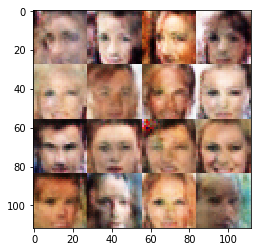

Epoch 0/1: Discriminator Loss: 1.3445, Generator Loss: 0.5837
Epoch 0/1: Discriminator Loss: 1.3600, Generator Loss: 0.4226
Epoch 0/1: Discriminator Loss: 1.2333, Generator Loss: 0.5058
Epoch 0/1: Discriminator Loss: 1.2913, Generator Loss: 0.6198


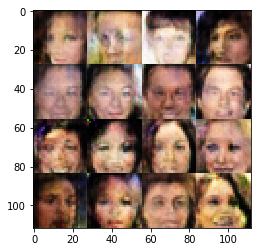

Epoch 0/1: Discriminator Loss: 1.2368, Generator Loss: 0.8443
Epoch 0/1: Discriminator Loss: 1.1813, Generator Loss: 0.6666
Epoch 0/1: Discriminator Loss: 1.2512, Generator Loss: 0.7200
Epoch 0/1: Discriminator Loss: 1.1354, Generator Loss: 0.7285


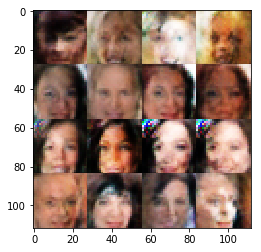

Epoch 0/1: Discriminator Loss: 1.1255, Generator Loss: 0.6689
Epoch 0/1: Discriminator Loss: 1.2333, Generator Loss: 0.8228
Epoch 0/1: Discriminator Loss: 1.3161, Generator Loss: 0.5557
Epoch 0/1: Discriminator Loss: 1.2156, Generator Loss: 0.5556


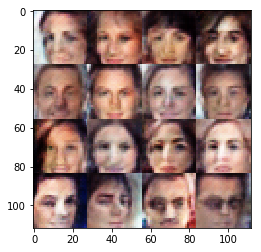

Epoch 0/1: Discriminator Loss: 1.2948, Generator Loss: 0.5222
Epoch 0/1: Discriminator Loss: 1.5180, Generator Loss: 0.3596
Epoch 0/1: Discriminator Loss: 1.2087, Generator Loss: 0.5896
Epoch 0/1: Discriminator Loss: 1.0810, Generator Loss: 0.6850


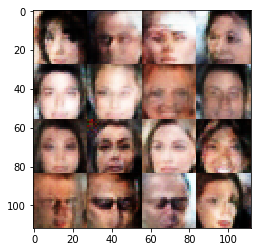

Epoch 0/1: Discriminator Loss: 1.0462, Generator Loss: 0.9572
Epoch 0/1: Discriminator Loss: 1.1881, Generator Loss: 0.7644


In [220]:
batch_size = 64
z_dim = 200
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.